In [1]:
%load_ext autoreload
%autoreload 2
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import r2_score
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
# Set Matplotlib parameters for better visualization
plt.rcParams['figure.figsize'] = (14, 8)
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('future.no_silent_downcasting', True)

In [3]:
# Colors for consistent city representation
PARIS_COLOR = 'blue'
LONDON_COLOR = 'green'

In [4]:
# ----------------------------------------------------------------------
# GLOBAL PARAMETERS
# ----------------------------------------------------------------------

In [5]:
LONDON_START_YEAR = 2012    # London rentals comparison start year
LONDON_END_YEAR = 2019      # London rentals comparison end year
LONDON_COMPARE_DIFF = True  # True: x-axis = price change; False: x-axis = price at END_YEAR
LONDON_XLS_SHEET = 'Raw data'  # Excel sheet name for London rentals data

In [31]:
# ----------------------------------------------------------------------
# UTILITY FUNCTIONS
# ----------------------------------------------------------------------

In [32]:
def create_point_from_coords(row, lon_idx, lat_idx):
    """Create a shapely Point from longitude and latitude columns"""
    try:
        lon, lat = row.iloc[lon_idx], row.iloc[lat_idx]
        return Point(lon, lat)
    except Exception as e:
        print(f"Error creating point: {e}")
        return None

def parse_paris_coords(coord_str):
    """Parse coordinate string from Paris data format"""
    try:
        lat_str, lon_str = coord_str.split(',')
        lat = float(lat_str.strip())
        lon = float(lon_str.strip())
        return Point(lon, lat)
    except Exception as e:
        print(f"Error parsing coordinates: {e}")
        return None
        
def convert_geojson_to_shape(geo_str):
    """Convert GeoJSON string to shapely geometry object"""
    try:
        geo_dict = json.loads(geo_str)
        return shape(geo_dict)
    except Exception as e:
        print(f"Error converting geometry: {e}")
        return None

def fit_polynomial_models(X, Y, max_degree=5):
    """Fit polynomial models of different degrees and perform cross-validation"""
    degrees = range(1, max_degree + 1)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results_list = []

    for deg in degrees:
        poly = PolynomialFeatures(degree=deg, include_bias=False)
        X_poly = poly.fit_transform(X)
        lr = LinearRegression()
        cv_results = cross_validate(lr, X_poly, Y, cv=kf, 
                                   scoring='neg_mean_squared_error', 
                                   return_train_score=True)
        train_mse = -np.mean(cv_results['train_score'])
        test_mse = -np.mean(cv_results['test_score'])
        cv_results_list.append({
            'degree': deg, 
            'train_mse': train_mse, 
            'test_mse': test_mse
        })
    
    return pd.DataFrame(cv_results_list)

# For the scatter plot of Airbnb densities
def plot_airbnb_density_scatter_comparison(paris_data, london_data):
    """Create side-by-side scatter plots comparing Airbnb density vs price changes"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Paris scatter plot
    axes[0].scatter(paris_data['price_increase'], paris_data['airbnb_density'], 
                alpha=0.7, color=PARIS_COLOR)
    axes[0].set_xlabel('Rental Price Increase (2024 - 2019) [€/m²]')
    axes[0].set_ylabel('Airbnb Density (listings/km²)')
    axes[0].set_title('Paris: Airbnb Density vs. Rental Price Increase')
    axes[0].grid(True, alpha=0.3)
    
    # London scatter plot
    axes[1].scatter(london_data['price_change'], london_data['airbnb_density'], 
                alpha=0.7, color=LONDON_COLOR)
    axes[1].set_xlabel(f'Rental Price Change ({LONDON_END_YEAR}–{LONDON_START_YEAR})')
    axes[1].set_ylabel('Airbnb Density (listings/km²)')
    axes[1].set_title('London: Airbnb Density vs. Rental Price Change')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, axes

# For the bias-variance trade-off plots
def plot_bias_variance_tradeoff_comparison(paris_cv_results, london_cv_results):
    """Plot bias-variance tradeoff curves for both cities side by side"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Paris curves
    axes[0].plot(paris_cv_results['degree'], paris_cv_results['train_mse'], 
             marker='o', color=PARIS_COLOR, linestyle='-', label='Training MSE')
    axes[0].plot(paris_cv_results['degree'], paris_cv_results['test_mse'], 
             marker='o', color=PARIS_COLOR, linestyle='--', label='Validation MSE')
    axes[0].set_xlabel('Polynomial Degree')
    axes[0].set_ylabel('Mean Squared Error')
    axes[0].set_title('Paris: Bias-Variance Trade-Off')
    axes[0].set_yscale('log')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # London curves
    axes[1].plot(london_cv_results['degree'], london_cv_results['train_mse'], 
             marker='s', color=LONDON_COLOR, linestyle='-', label='Training MSE')
    axes[1].plot(london_cv_results['degree'], london_cv_results['test_mse'], 
             marker='s', color=LONDON_COLOR, linestyle='--', label='Validation MSE')
    axes[1].set_xlabel('Polynomial Degree')
    axes[1].set_ylabel('Mean Squared Error')
    axes[1].set_title('London: Bias-Variance Trade-Off')
    axes[1].set_yscale('log')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, axes

# For polynomial regression plots
def plot_polynomial_regression_comparison(paris_X, paris_Y, paris_poly, paris_model, paris_r, paris_deg,
                                         london_X, london_Y, london_poly, london_model, london_r, london_deg):
    """Plot polynomial regression curves for both cities side by side"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Paris regression
    paris_X_range = np.linspace(paris_X.min(), paris_X.max(), 100).reshape(-1, 1)
    paris_X_range_poly = paris_poly.transform(paris_X_range)
    paris_Y_pred = paris_model.predict(paris_X_range_poly)
    
    axes[0].scatter(paris_X, paris_Y, alpha=0.7, color=PARIS_COLOR, label='Neighborhoods')
    axes[0].plot(paris_X_range, paris_Y_pred, color=PARIS_COLOR, linestyle='--', 
             label=f'Polynomial Regression (deg {paris_deg}, R = {paris_r:.2f})')
    axes[0].set_xlabel('Rental Price Increase (2024 - 2019) [€/m²]')
    axes[0].set_ylabel('Airbnb Density (listings/km²)')
    axes[0].set_title('Paris: Airbnb Density vs. Rental Price Increase')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # London regression
    london_X_range = np.linspace(london_X.min(), london_X.max(), 100).reshape(-1, 1)
    london_X_range_poly = london_poly.transform(london_X_range)
    london_Y_pred = london_model.predict(london_X_range_poly)
    
    axes[1].scatter(london_X, london_Y, alpha=0.7, color=LONDON_COLOR, label='Neighborhoods')
    axes[1].plot(london_X_range, london_Y_pred, color=LONDON_COLOR, linestyle='--', 
             label=f'Polynomial Regression (deg {london_deg}, R = {london_r:.2f})')
    axes[1].set_xlabel(f'Rental Price Change ({LONDON_END_YEAR}–{LONDON_START_YEAR})')
    axes[1].set_ylabel('Airbnb Density (listings/km²)')
    axes[1].set_title('London: Airbnb Density vs. Rental Price Change')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, axes

# For density distribution as bar chart instead of KDE
def plot_density_distribution_comparison(paris_data, london_data):
    """Create side-by-side histograms with KDE curves for Airbnb density distributions"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Paris density distribution
    sns.histplot(
        paris_data['airbnb_density'], 
        kde=True, 
        ax=axes[0], 
        color=PARIS_COLOR,
        stat='density',
        bins=15,
        alpha=0.7
    )
    axes[0].set_title('Paris: Airbnb Density Distribution', fontsize=14)
    axes[0].set_xlabel('Airbnb Density (listings/km²)', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # London density distribution
    sns.histplot(
        london_data['airbnb_density'], 
        kde=True, 
        ax=axes[1], 
        color=LONDON_COLOR,
        stat='density',
        bins=15,
        alpha=0.7
    )
    axes[1].set_title('London: Airbnb Density Distribution', fontsize=14)
    axes[1].set_xlabel('Airbnb Density (listings/km²)', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    # Improve layout
    plt.tight_layout()
    return fig, axes

def fit_best_model(X, Y, cv_results_df):
    """Fit the best polynomial model based on cross-validation results"""
    best_row = cv_results_df.loc[cv_results_df['test_mse'].idxmin()]
    best_deg = int(best_row['degree'])
    print(f"Best Polynomial Degree: {best_deg}")
    
    poly_best = PolynomialFeatures(degree=best_deg, include_bias=False)
    X_poly_best = poly_best.fit_transform(X)
    lr_best = LinearRegression()
    lr_best.fit(X_poly_best, Y)
    r2_best = lr_best.score(X_poly_best, Y)
    r_best = np.sqrt(r2_best) if r2_best >= 0 else 0
    
    return best_deg, poly_best, lr_best, r_best


def plot_boxplot_comparison(paris_df, london_df):
    """Create side-by-side boxplots for both cities"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Paris boxplot
    sns.boxplot(x='price_increase_bin', y='airbnb_density', data=paris_df, ax=axes[0], color=PARIS_COLOR)
    axes[0].set_title("Paris: Distribution of Airbnb Density by Price Increase Bins")
    axes[0].set_xlabel("Rental Price Increase (2024 - 2019) [€/m²] (Binned)")
    axes[0].set_ylabel("Airbnb Density (listings per km²)")
    axes[0].tick_params(axis='x', rotation=45)
    
    # London boxplot
    sns.boxplot(x='price_bin', y='airbnb_density', data=london_df, ax=axes[1], color=LONDON_COLOR)
    axes[1].set_title(f"London: Distribution of Airbnb Density by Price Change Bins")
    axes[1].set_xlabel(f"Price Change ({LONDON_END_YEAR}–{LONDON_START_YEAR}) Quintile")
    axes[1].set_ylabel("Airbnb Density (listings per km²)")
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig, axes

def plot_quadratic_fit_comparison(paris_df, london_df):
    """Plot quadratic fits on binned data for both cities with R² values"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Paris quadratic fit
    paris_bin_stats = paris_df.groupby('price_increase_bin', observed=False).agg({
        'price_increase': 'mean', 
        'airbnb_density': 'median'
    }).reset_index()
    
    paris_X = paris_bin_stats['price_increase'].values.reshape(-1, 1)
    paris_y = paris_bin_stats['airbnb_density'].values
    
    paris_poly = PolynomialFeatures(degree=2, include_bias=False)
    paris_X_poly = paris_poly.fit_transform(paris_X)
    paris_model = LinearRegression()
    paris_model.fit(paris_X_poly, paris_y)
    
    # Calculate R² for Paris model
    paris_y_pred = paris_model.predict(paris_X_poly)
    paris_r2 = r2_score(paris_y, paris_y_pred)
    
    paris_X_curve = np.linspace(paris_df['price_increase'].min(), paris_df['price_increase'].max(), 100).reshape(-1, 1)
    paris_y_curve = paris_model.predict(paris_poly.transform(paris_X_curve))
    
    axes[0].scatter(paris_X, paris_y, color=PARIS_COLOR, s=80, label='Bin Medians')
    axes[0].plot(paris_X_curve, paris_y_curve, color=PARIS_COLOR, linestyle='--', label='Quadratic Fit')
    
    # Add bin edge vertical lines for Paris
    paris_bin_edges = pd.unique(paris_df['price_increase_bin'].cat.categories.right.values[:-1])
    for edge in paris_bin_edges:
        axes[0].axvline(x=edge, color='gray', linestyle=':', alpha=0.5)
    
    axes[0].set_title(f"Paris: Quadratic Regression on Binned Data (R² = {paris_r2:.3f})")
    axes[0].set_xlabel("Mean Price Increase (2024 - 2019) (€/m²)")
    axes[0].set_ylabel("Median Airbnb Density (listings/km²)")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # London quadratic fit
    london_bin_stats = london_df.groupby('price_bin', observed=False).agg({
        'price_change': 'mean', 
        'airbnb_density': 'median'
    }).reset_index()
    
    london_X = london_bin_stats['price_change'].values.reshape(-1, 1)
    london_y = london_bin_stats['airbnb_density'].values
    
    london_poly = PolynomialFeatures(degree=2, include_bias=False)
    london_X_poly = london_poly.fit_transform(london_X)
    london_model = LinearRegression()
    london_model.fit(london_X_poly, london_y)
    
    # Calculate R² for London model
    london_y_pred = london_model.predict(london_X_poly)
    london_r2 = r2_score(london_y, london_y_pred)
    
    london_X_curve = np.linspace(london_df['price_change'].min(), london_df['price_change'].max(), 100).reshape(-1, 1)
    london_y_curve = london_model.predict(london_poly.transform(london_X_curve))
    
    axes[1].scatter(london_X, london_y, color=LONDON_COLOR, s=80, label='Bin Medians')
    axes[1].plot(london_X_curve, london_y_curve, color=LONDON_COLOR, linestyle='--', label='Quadratic Fit')
    
    # Add bin edge vertical lines for London
    london_bin_edges = pd.unique(london_df['price_bin'].cat.categories.right.values[:-1])
    for edge in london_bin_edges:
        axes[1].axvline(x=edge, color='gray', linestyle=':', alpha=0.5)
    
    axes[1].set_title(f"London: Quadratic Regression on Binned Data (R² = {london_r2:.3f})")
    axes[1].set_xlabel(f"Mean Price Change ({LONDON_END_YEAR}–{LONDON_START_YEAR})")
    axes[1].set_ylabel("Median Airbnb Density (listings/km²)")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, axes

# For correlation bar chart
def plot_correlation_bar_chart(paris_corr, london_corr, paris_pvalue, london_pvalue):
    """Plot a bar chart comparing Pearson correlations for Paris and London with p-value annotations."""
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        ['Paris', 'London'],
        [paris_corr, london_corr],
        color=[PARIS_COLOR, LONDON_COLOR],
        edgecolor='black',
        alpha=0.85
    )
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.4, linewidth=1)
    plt.ylim(-1, 1)
    plt.title('Correlation between Rental Price Changes and Airbnb Density', fontsize=16, fontweight='bold')
    plt.ylabel('Pearson Correlation Coefficient', fontsize=13)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', alpha=0.3, linestyle=':')
    
    # Annotate correlation values on bars
    for idx, (corr, pval) in enumerate(zip([paris_corr, london_corr], [paris_pvalue, london_pvalue])):
        plt.text(
            idx, corr + (0.07 if corr > 0 else -0.13),
            f"r={corr:.2f}\np={pval:.4f}",
            ha='center', va='bottom' if corr > 0 else 'top',
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7)
        )
    
    plt.tight_layout()

In [33]:
# ----------------------------------------------------------------------
# DATA LOADING & PROCESSING
# ----------------------------------------------------------------------

In [34]:
def load_paris_data():
    print("\n" + "="*50)
    print("LOADING PARIS DATA")
    print("="*50)
    
    # Load Paris rental data
    df_rentals_initial = pd.read_csv("../data/paris_rentals.csv", 
                                     delimiter=';', 
                                     on_bad_lines='skip', 
                                     encoding='utf-8')
    
    # Use fine grid neighborhoods from rentals data
    df_neigh = df_rentals_initial.drop_duplicates(subset="Numéro du quartier")
    df_neigh = df_neigh[["Numéro du quartier", "geo_shape"]]
    print(f"Number of unique Paris neighborhoods: {len(df_neigh)}")
    
    # Rename and convert the GeoJSON geometry to Shapely objects
    df_neigh.rename(columns={"Numéro du quartier": "neigh_id"}, inplace=True)
    df_neigh["geometry"] = df_neigh["geo_shape"].apply(convert_geojson_to_shape)
    gdf_neigh = gpd.GeoDataFrame(df_neigh, geometry="geometry", crs="EPSG:4326")
    
    # Load Paris Airbnb data
    df_airbnb = pd.read_csv("../data/paris_airbnb.csv", 
                            delimiter=',', 
                            on_bad_lines='skip', 
                            encoding='utf-8')
    
    # Create point geometry from latitude and longitude
    df_airbnb['geometry'] = df_airbnb.apply(lambda row: create_point_from_coords(row, 7, 6), axis=1)
    df_airbnb = df_airbnb[df_airbnb['geometry'].notnull()]
    gdf_airbnb = gpd.GeoDataFrame(df_airbnb, geometry='geometry', crs="EPSG:4326")
    
    # Spatial join: assign Airbnb listings to neighborhoods
    gdf_airbnb_joined = gpd.sjoin(gdf_airbnb, gdf_neigh, how='left', predicate='within')
    airbnb_counts = gdf_airbnb_joined.groupby('neigh_id').size().reset_index(name='airbnb_count')
    gdf_neigh = gdf_neigh.merge(airbnb_counts, on='neigh_id', how='left')
    gdf_neigh['airbnb_count'] = gdf_neigh['airbnb_count'].fillna(0).astype(int)
    
    # Compute area in km² and calculate density
    gdf_neigh['area_km2'] = gdf_neigh.to_crs(epsg=3857).area / 1e6
    gdf_neigh['airbnb_density'] = gdf_neigh['airbnb_count'] / gdf_neigh['area_km2']
    print(f"Total number of Airbnb listings in Paris: {len(gdf_airbnb)}")
    
    # Filter rental data by year
    df_rentals_2024 = df_rentals_initial[df_rentals_initial.iloc[:, 0] == 2024].copy()
    df_rentals_2019 = df_rentals_initial[df_rentals_initial.iloc[:, 0] == 2019].copy()
    
    # Parse coordinates and rental prices
    df_rentals_2024['geometry'] = df_rentals_2024.iloc[:, 13].apply(parse_paris_coords)
    df_rentals_2019['geometry'] = df_rentals_2019.iloc[:, 13].apply(parse_paris_coords)
    
    # Rental price is assumed to be in column index 7
    df_rentals_2024['rental_price'] = pd.to_numeric(df_rentals_2024.iloc[:, 7], errors='coerce')
    df_rentals_2019['rental_price'] = pd.to_numeric(df_rentals_2019.iloc[:, 7], errors='coerce')
    
    # Filter valid entries
    df_rentals_2024 = df_rentals_2024[df_rentals_2024['geometry'].notnull() & df_rentals_2024['rental_price'].notnull()]
    df_rentals_2019 = df_rentals_2019[df_rentals_2019['geometry'].notnull() & df_rentals_2019['rental_price'].notnull()]
    
    # Create GeoDataFrames
    gdf_rentals_2024 = gpd.GeoDataFrame(df_rentals_2024, geometry='geometry', crs="EPSG:4326")
    gdf_rentals_2019 = gpd.GeoDataFrame(df_rentals_2019, geometry='geometry', crs="EPSG:4326")
    
    # Spatial join rentals to neighborhoods
    gdf_rentals_2024_joined = gpd.sjoin(gdf_rentals_2024, gdf_neigh, how='left', predicate='within')
    gdf_rentals_2019_joined = gpd.sjoin(gdf_rentals_2019, gdf_neigh, how='left', predicate='within')
    
    # Calculate average prices for each neighborhood
    avg_prices_2024 = gdf_rentals_2024_joined.groupby('neigh_id')['rental_price'].mean().reset_index(name='avg_rental_price_2024')
    gdf_neigh = gdf_neigh.merge(avg_prices_2024, on='neigh_id', how='left')
    gdf_neigh['avg_rental_price_2024'] = gdf_neigh['avg_rental_price_2024'].fillna(0)
    
    avg_prices_2019 = gdf_rentals_2019_joined.groupby('neigh_id')['rental_price'].mean().reset_index(name='avg_rental_price_2019')
    gdf_neigh = gdf_neigh.merge(avg_prices_2019, on='neigh_id', how='left')
    gdf_neigh['avg_rental_price_2019'] = gdf_neigh['avg_rental_price_2019'].fillna(0)
    
    # Compute rental price increase (2024 - 2019)
    gdf_neigh['price_increase'] = gdf_neigh['avg_rental_price_2024'] - gdf_neigh['avg_rental_price_2019']
    
    return gdf_neigh

In [35]:
def load_london_data():
    print("\n" + "="*50)
    print("LOADING LONDON DATA")
    print("="*50)
    
    # File paths
    excel_rentals = "../data/london_rentals.xls"        # rentals data
    csv_airbnb = "../data/london_airbnb.csv"           # Airbnb listings
    geojson_neigh = "../data/london_neighbourhoods.geojson"  # neighbourhood shapes
    
    # Load Airbnb listings
    df_airbnb = pd.read_csv(csv_airbnb, encoding="utf-8")
    
    # Build GeoDataFrame for Airbnb data
    DF = df_airbnb.copy()
    DF['geometry'] = DF.apply(lambda row: create_point_from_coords(row, 7, 6), axis=1)
    DF = DF[DF['geometry'].notnull()]
    gdf_airbnb = gpd.GeoDataFrame(DF, geometry='geometry', crs='EPSG:4326')
    
    # Load and process rental data
    # positional column indices in the Excel
    YEAR_COL, QUARTER_COL, NEIGH_COL, CATEGORY_COL, PRICE_COL = 0, 1, 3, 4, 6
    NEIGH_NAME = 'neighbourhood'
    
    # read raw rentals sheet
    raw = pd.read_excel(excel_rentals, sheet_name=LONDON_XLS_SHEET, header=None)
    raw.rename(columns={NEIGH_COL: NEIGH_NAME}, inplace=True)
    
    # filter by years, Q1, all categories
    df_filt = raw[(raw.iloc[:, YEAR_COL].isin([LONDON_START_YEAR, LONDON_END_YEAR])) &
                   (raw.iloc[:, QUARTER_COL]=='Q1') &
                   (raw.iloc[:, CATEGORY_COL]=='All categories')].copy()
    
    # parse price and drop NAs
    df_filt[PRICE_COL] = pd.to_numeric(df_filt.iloc[:, PRICE_COL], errors='coerce')
    df_filt.dropna(subset=[NEIGH_NAME, PRICE_COL], inplace=True)
    
    # average price per neighbourhood per year
    avg_start = df_filt[df_filt.iloc[:, YEAR_COL]==LONDON_START_YEAR]
    avg_start = avg_start.groupby(NEIGH_NAME)[PRICE_COL].mean().reset_index(name=f"avg_price_{LONDON_START_YEAR}")
    avg_end = df_filt[df_filt.iloc[:, YEAR_COL]==LONDON_END_YEAR]
    avg_end = avg_end.groupby(NEIGH_NAME)[PRICE_COL].mean().reset_index(name=f"avg_price_{LONDON_END_YEAR}")
    
    # merge average prices
    df_rentals = pd.merge(avg_start, avg_end, on=NEIGH_NAME, how='outer').fillna(0)
    
    # compute price change always
    df_rentals['price_change'] = df_rentals[f"avg_price_{LONDON_END_YEAR}"] - df_rentals[f"avg_price_{LONDON_START_YEAR}"]
    
    # Merge with neighbourhood geometries and compute Airbnb density
    gdf_neigh = gpd.read_file(geojson_neigh)
    gdf_neigh = gdf_neigh.merge(df_rentals, on=NEIGH_NAME, how='left').fillna(0)
    joined = gpd.sjoin(gdf_airbnb, gdf_neigh, how='left', predicate='within')
    counts = joined.groupby('neighbourhood_right').size().reset_index(name='airbnb_count')
    counts.rename(columns={'neighbourhood_right':'neighbourhood'}, inplace=True)
    gdf_neigh = gdf_neigh.merge(counts, on='neighbourhood', how='left').fillna({'airbnb_count':0})
    gdf_neigh['area_km2'] = gdf_neigh.to_crs(epsg=3857).area / 1e6
    gdf_neigh['airbnb_density'] = gdf_neigh['airbnb_count'] / gdf_neigh['area_km2']
    
    print(f"Number of unique London neighborhoods: {len(gdf_neigh)}")
    print(f"Total Airbnb listings in London: {len(gdf_airbnb)}")
    
    return gdf_neigh

In [36]:
# ----------------------------------------------------------------------
# COMPARATIVE ANALYSIS
# ----------------------------------------------------------------------

In [27]:
# Load data for both cities
paris_data = load_paris_data()
london_data = load_london_data()


LOADING PARIS DATA
Number of unique Paris neighborhoods: 80
Total number of Airbnb listings in Paris: 91031

LOADING LONDON DATA
Number of unique London neighborhoods: 33
Total Airbnb listings in London: 95144


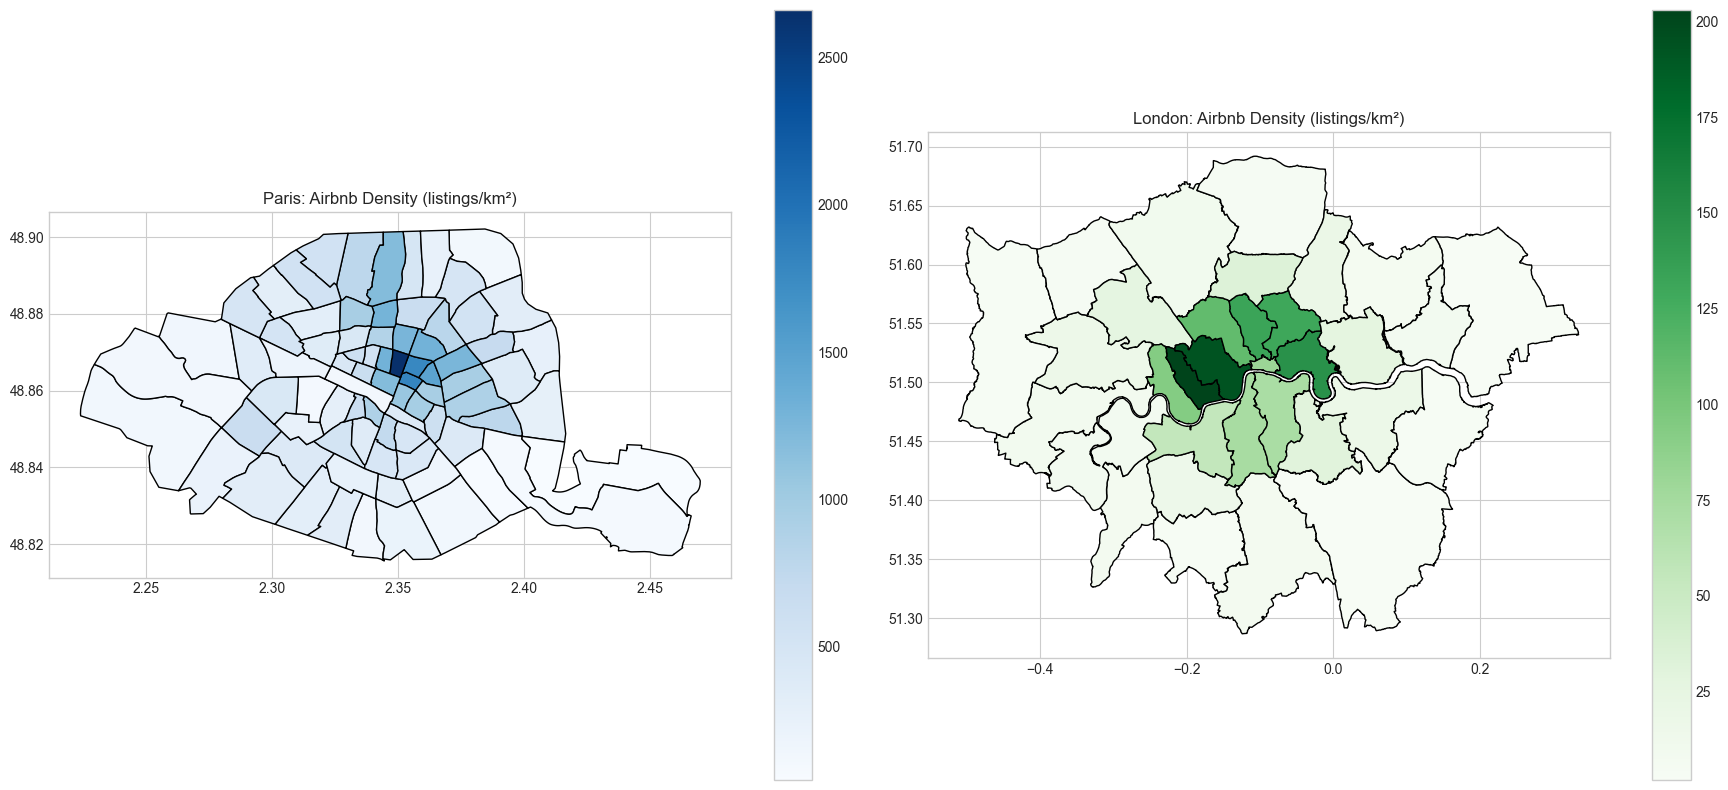

In [37]:
# 1. Airbnb Density Maps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

paris_data.plot(column='airbnb_density', cmap='Blues', legend=True, ax=axes[0], edgecolor='black')
axes[0].set_title('Paris: Airbnb Density (listings/km²)')

london_data.plot(column='airbnb_density', cmap='Greens', legend=True, ax=axes[1], edgecolor='black')
axes[1].set_title('London: Airbnb Density (listings/km²)')

plt.tight_layout()
plt.show()

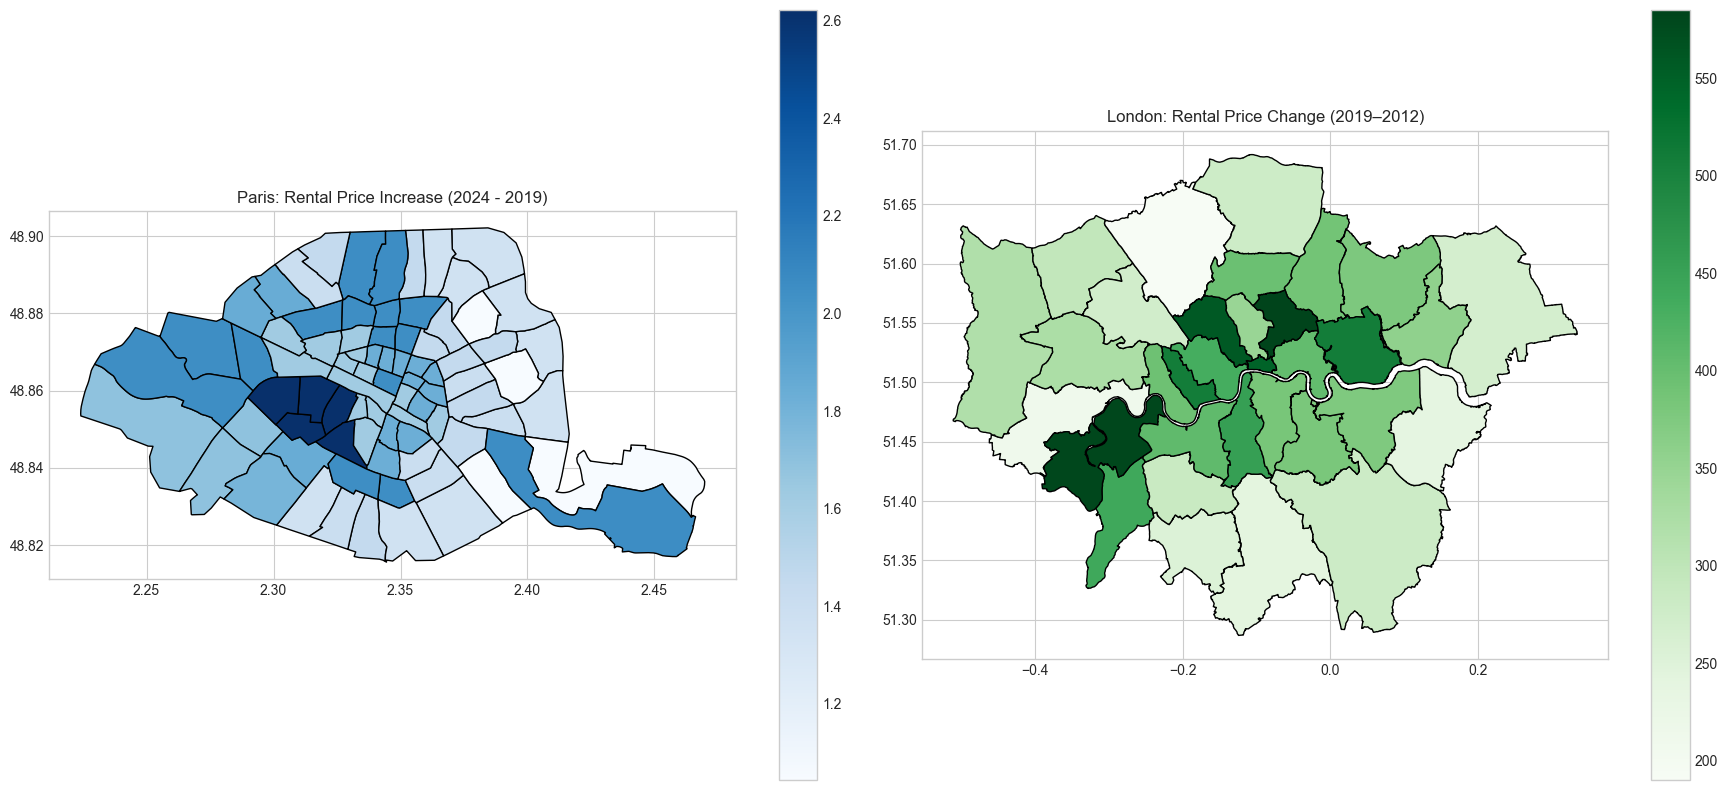

In [38]:
# 2. Rental Price Increase Maps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

paris_data.plot(column='price_increase', cmap='Blues', legend=True, ax=axes[0], edgecolor='black')
axes[0].set_title('Paris: Rental Price Increase (2024 - 2019)')

london_data.plot(column='price_change', cmap='Greens', legend=True, ax=axes[1], edgecolor='black')
axes[1].set_title(f'London: Rental Price Change ({LONDON_END_YEAR}–{LONDON_START_YEAR})')

plt.tight_layout()
plt.show()

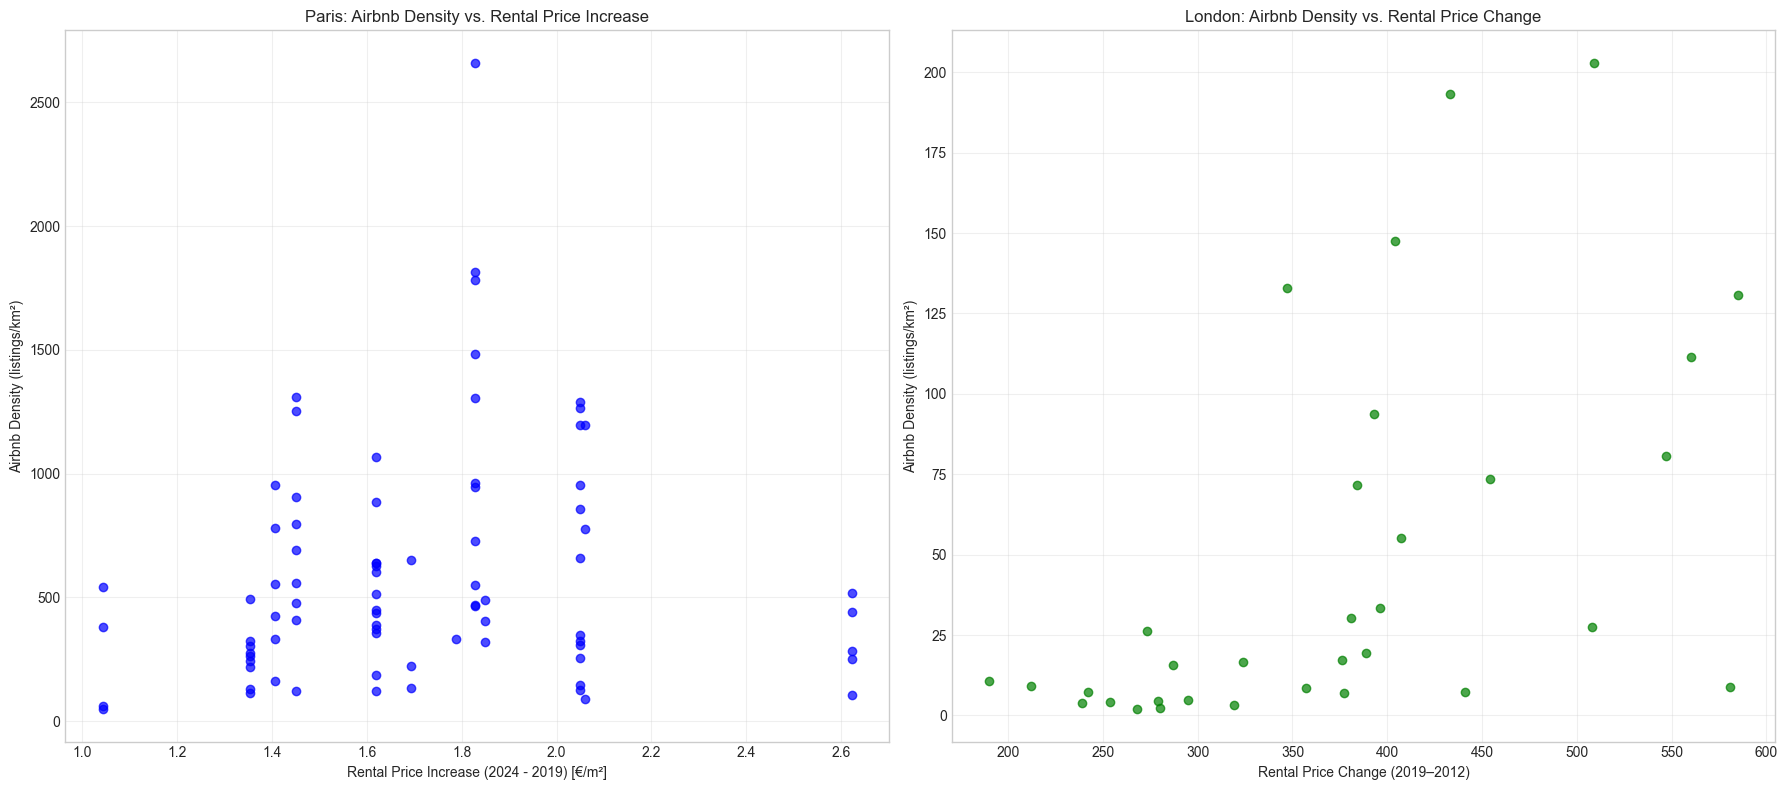

In [39]:
# 3. Scatter Plot: Airbnb Density vs Price Increase
fig, axes = plot_airbnb_density_scatter_comparison(paris_data, london_data)
plt.show()


Paris Cross-validation results:
   degree      train_mse       test_mse
0       1  209862.656447  220447.592506
1       2  186797.391119  194262.343321
2       3  185442.429066  194714.486262
3       4  180762.044123  204406.952949
4       5  176063.954118  211172.469379

London Cross-validation results:
   degree    train_mse     test_mse
0       1  2209.681820  3135.141902
1       2  2165.848262  3241.828847
2       3  1974.413427  3323.573902
3       4  1946.130070  3608.187326
4       5  1915.081453  3954.846859


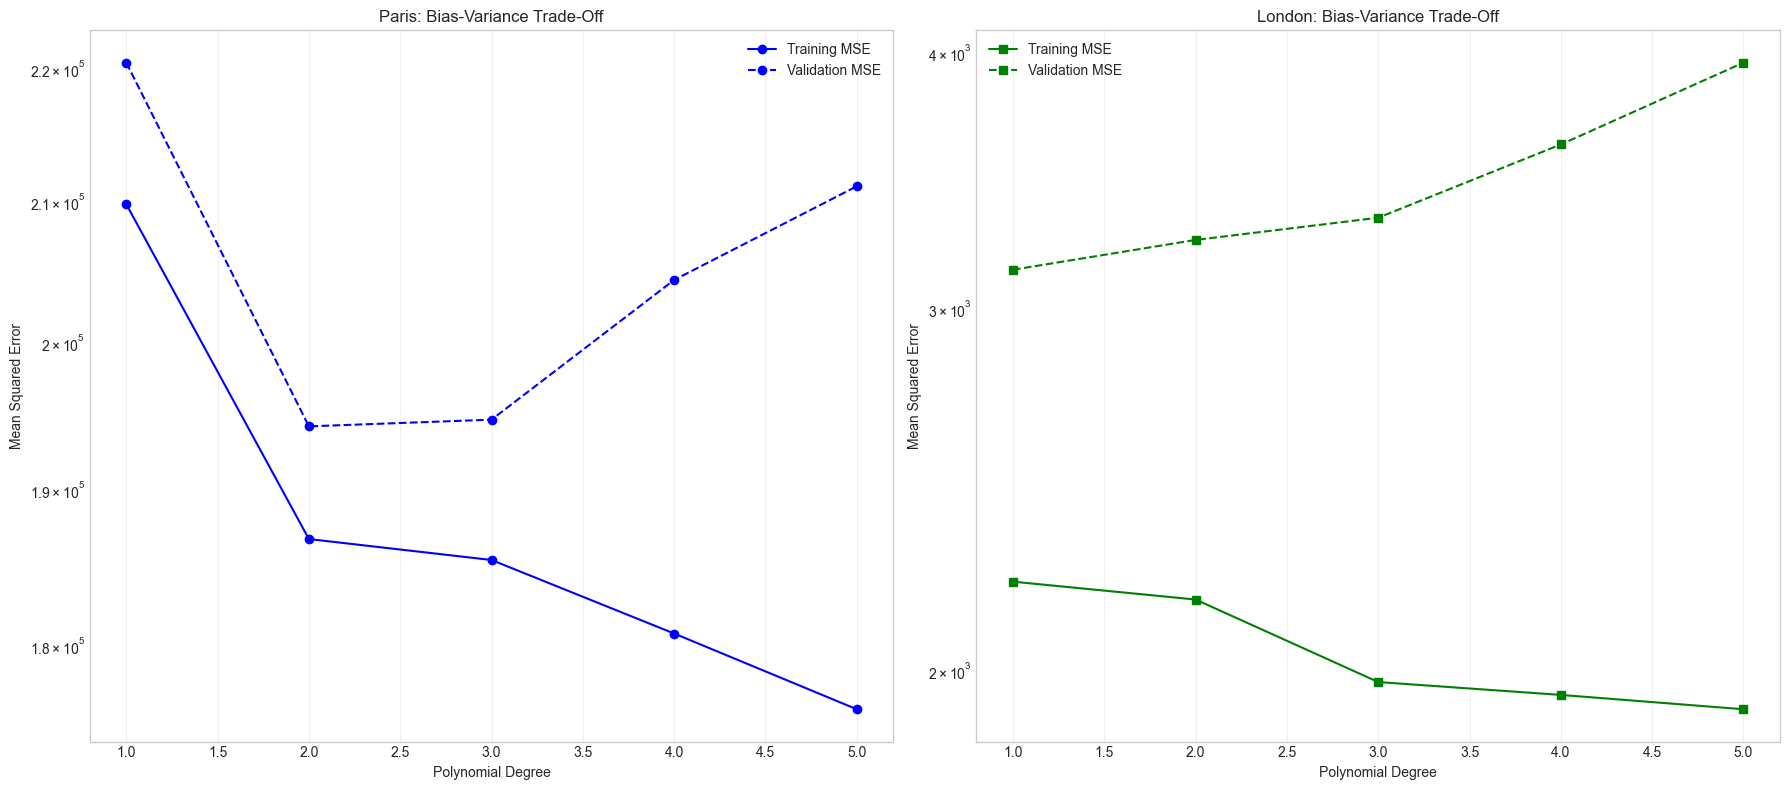

In [40]:
# 4. Bias-Variance Trade-off Analysis
paris_X = paris_data['price_increase'].values.reshape(-1, 1)
paris_Y = paris_data['airbnb_density'].values
paris_cv_results = fit_polynomial_models(paris_X, paris_Y)
print("\nParis Cross-validation results:")
print(paris_cv_results)

london_X = london_data['price_change'].values.reshape(-1, 1)
london_Y = london_data['airbnb_density'].values
london_cv_results = fit_polynomial_models(london_X, london_Y)
print("\nLondon Cross-validation results:")
print(london_cv_results)

fig, axes = plot_bias_variance_tradeoff_comparison(paris_cv_results, london_cv_results)
plt.show()

Best Polynomial Degree: 2
Best Polynomial Degree: 1


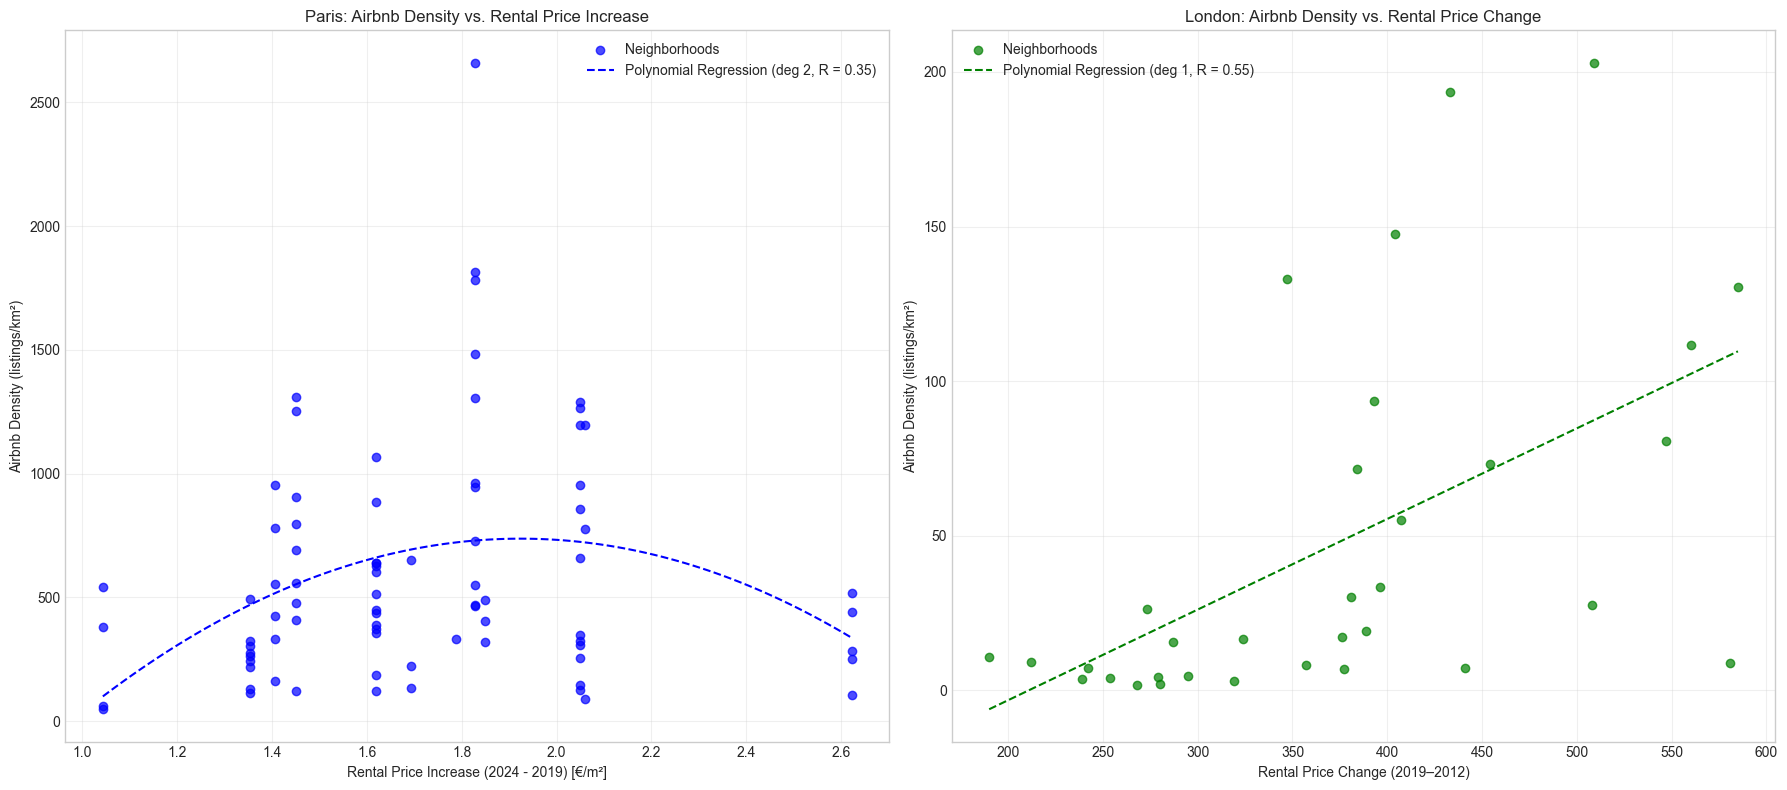

In [41]:
# Fit best models for both cities
paris_best_deg, paris_poly, paris_model, paris_r = fit_best_model(paris_X, paris_Y, paris_cv_results)
london_best_deg, london_poly, london_model, london_r = fit_best_model(london_X, london_Y, london_cv_results)

# Plot polynomial regression comparison - SIDE BY SIDE
fig, axes = plot_polynomial_regression_comparison(
    paris_X, paris_Y, paris_poly, paris_model, paris_r, paris_best_deg,
    london_X, london_Y, london_poly, london_model, london_r, london_best_deg
)
plt.show()

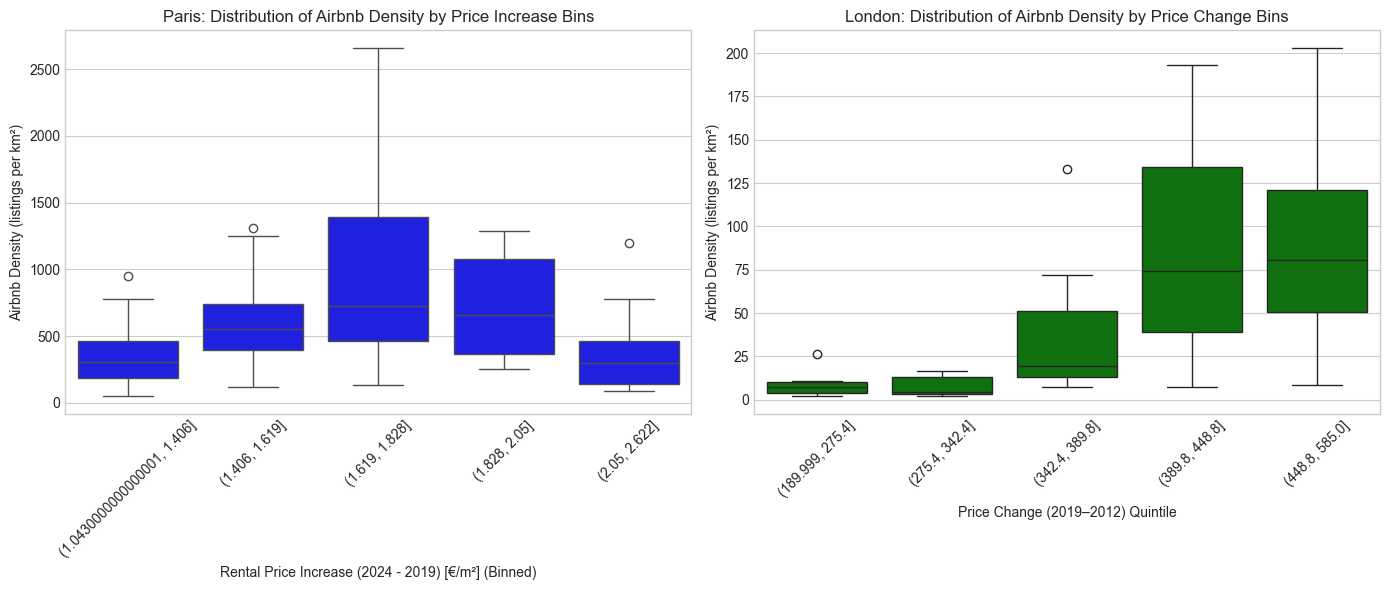

In [42]:
# 5. Box Plots - Bin the data first
paris_data['price_increase_bin'] = pd.qcut(paris_data['price_increase'], q=5, duplicates='drop')
london_data['price_bin'] = pd.qcut(london_data['price_change'], q=5, duplicates='drop')

plot_boxplot_comparison(paris_data, london_data)
plt.show()

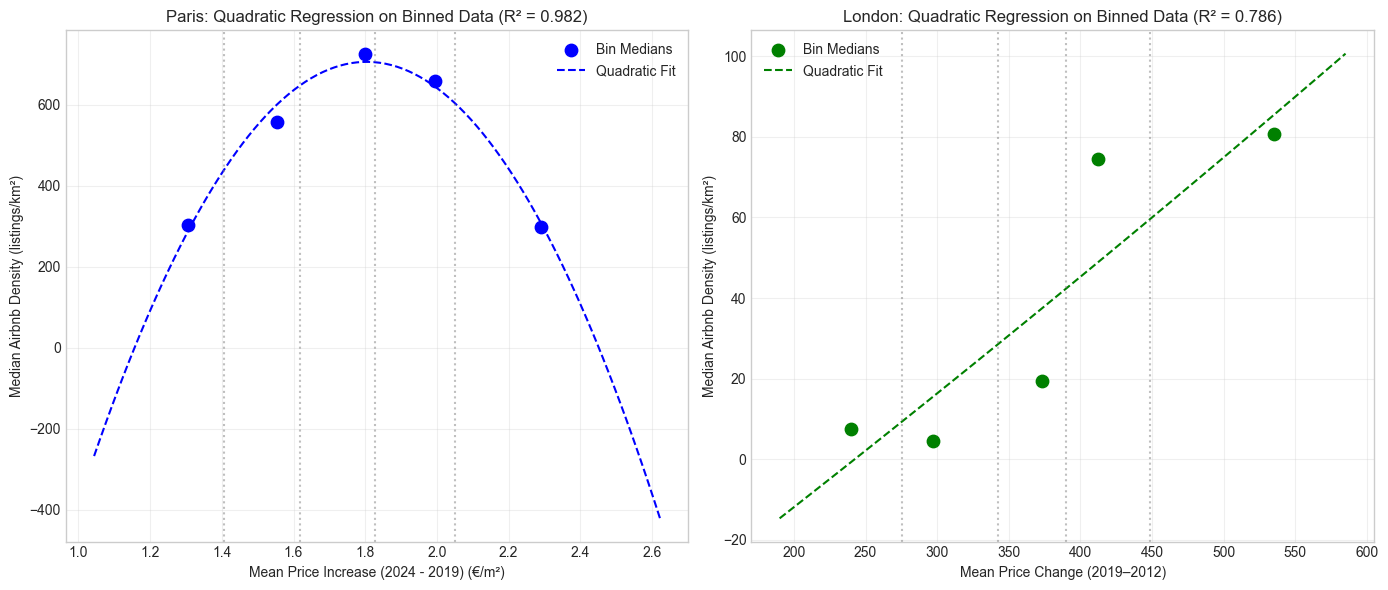

In [43]:
# 6. Quadratic Regression on Binned Data
plot_quadratic_fit_comparison(paris_data, london_data)
plt.show()

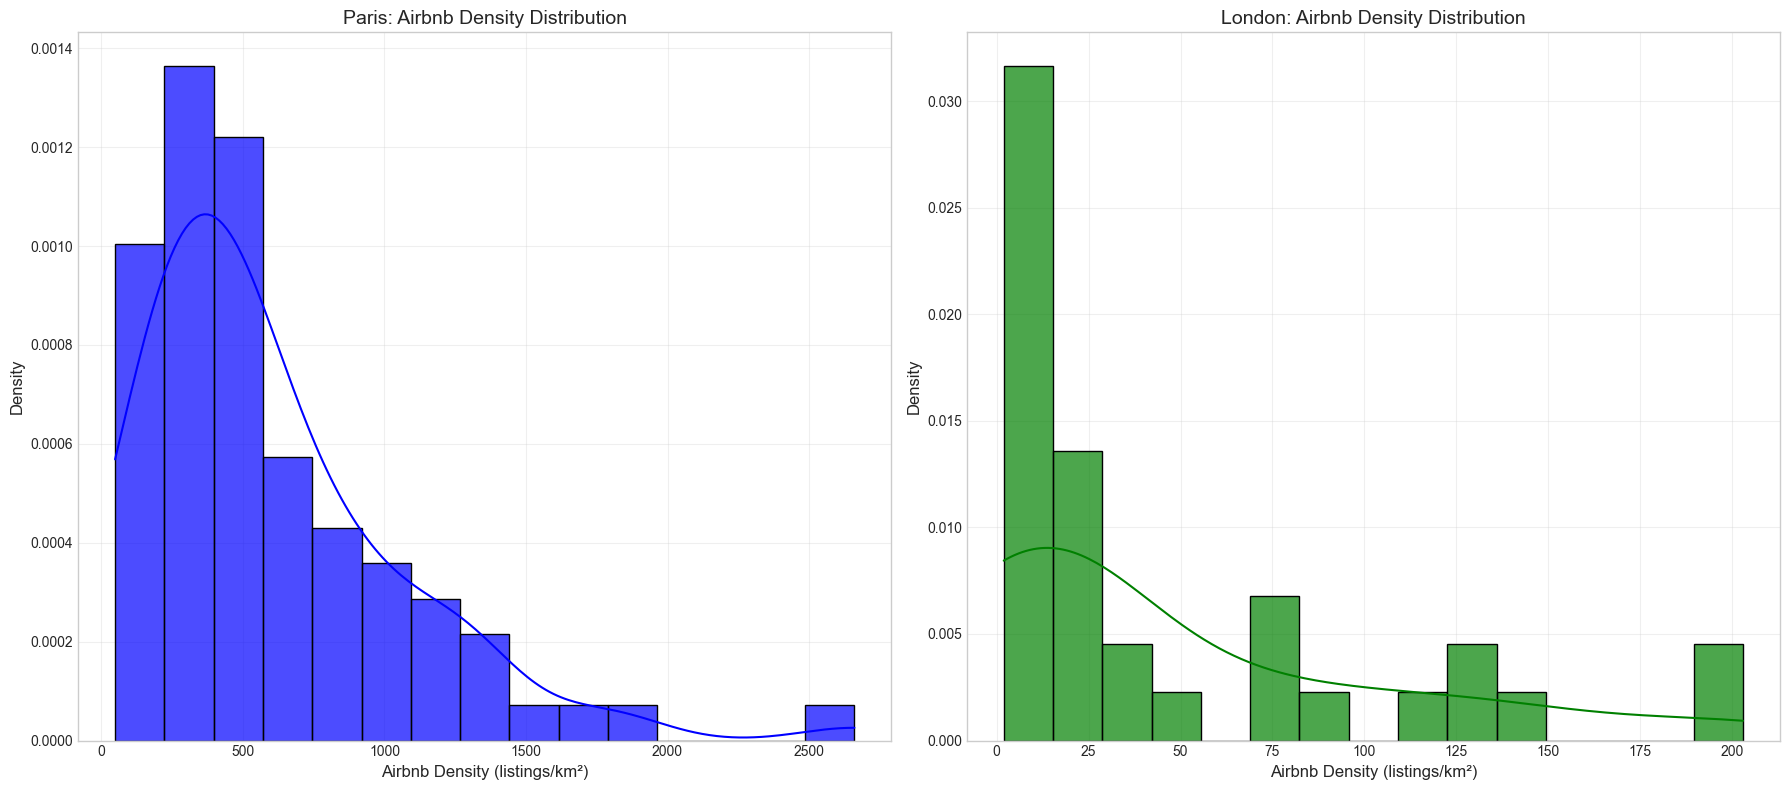

In [44]:
# 7. Density Distribution Comparison
fig, ax = plot_density_distribution_comparison(paris_data, london_data)
plt.show()


CORRELATION ANALYSIS
Paris - Correlation between Price Increase and Airbnb Density: 0.121 (p-value: 0.2867)
London - Correlation between Price Change and Airbnb Density: 0.547 (p-value: 0.0010)


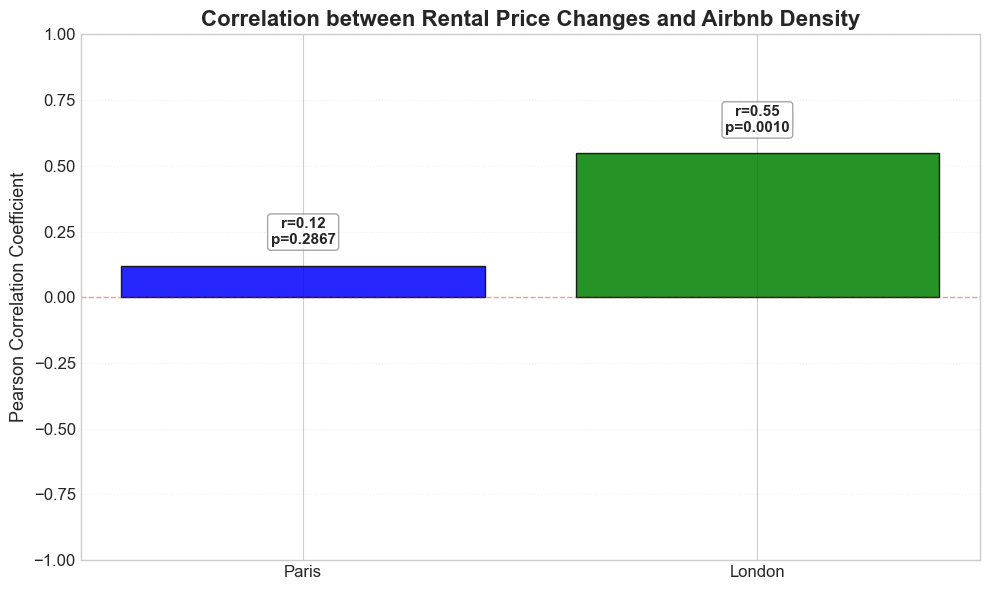

In [45]:
# 8. Pearson Correlation Comparison
paris_corr, paris_pvalue = pearsonr(paris_data['price_increase'], paris_data['airbnb_density'])
london_corr, london_pvalue = pearsonr(london_data['price_change'], london_data['airbnb_density'])

print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)
print(f"Paris - Correlation between Price Increase and Airbnb Density: {paris_corr:.3f} (p-value: {paris_pvalue:.4f})")
print(f"London - Correlation between Price Change and Airbnb Density: {london_corr:.3f} (p-value: {london_pvalue:.4f})")

# Create correlation bar chart
plot_correlation_bar_chart(paris_corr, london_corr, paris_pvalue, london_pvalue)
plt.show()

In [46]:
# Final conclusions
print("\n" + "="*50)
print("CONCLUSIONS")
print("="*50)

significant_paris = paris_pvalue < 0.05
significant_london = london_pvalue < 0.05

print("Paris Analysis:")
print(f"- The correlation coefficient of {paris_corr:.3f} is {'statistically significant' if significant_paris else 'not statistically significant'}")
print(f"- Neighborhoods with {'higher' if paris_corr > 0 else 'lower'} rental price increases tend to have {'higher' if paris_corr > 0 else 'lower'} Airbnb density")

print("\nLondon Analysis:")
print(f"- The correlation coefficient of {london_corr:.3f} is {'statistically significant' if significant_london else 'not statistically significant'}")
print(f"- Neighborhoods with {'higher' if london_corr > 0 else 'lower'} rental price changes tend to have {'higher' if london_corr > 0 else 'lower'} Airbnb density")

print("\nComparison:")
if (paris_corr > 0) == (london_corr > 0):
    print("- Both cities show a similar directional relationship between rental price changes and Airbnb density")
else:
    print("- The cities show opposite directional relationships between rental price changes and Airbnb density")

print("- Paris shows a", abs(paris_corr) > abs(london_corr) and "stronger" or "weaker", "correlation than London")

print("\nLimitations and Future Work:")
print("- This analysis is correlational and does not prove causation")
print("- Time periods differ between cities (Paris: 2019-2024, London:", f"{LONDON_START_YEAR}-{LONDON_END_YEAR})")
print("- Different neighborhood definitions and sizes may affect the analysis")
print("- Future work should consider additional variables like tourism, economic growth, and housing policies")
print("- Panel data analysis over more years would provide more robust insights")


CONCLUSIONS
Paris Analysis:
- The correlation coefficient of 0.121 is not statistically significant
- Neighborhoods with higher rental price increases tend to have higher Airbnb density

London Analysis:
- The correlation coefficient of 0.547 is statistically significant
- Neighborhoods with higher rental price changes tend to have higher Airbnb density

Comparison:
- Both cities show a similar directional relationship between rental price changes and Airbnb density
- Paris shows a weaker correlation than London

Limitations and Future Work:
- This analysis is correlational and does not prove causation
- Time periods differ between cities (Paris: 2019-2024, London: 2012-2019)
- Different neighborhood definitions and sizes may affect the analysis
- Future work should consider additional variables like tourism, economic growth, and housing policies
- Panel data analysis over more years would provide more robust insights
